<a href="https://colab.research.google.com/github/carlosdcorona/PySpark/blob/main/K-MeanspySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classwork 13: K-Means

### Bernardo Samuel Salazar de Hoyos A00825722
### Carlos Daniel Corona Cortez A01656002
### Sebastian Andres Saldaña Cárdenas A01570274
### Sergio Noé Torres Rodríguez A00825706
### Raúl V. Ramírez Velarde
### November 1st, 2022

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop2.7.tgz
!tar xf spark-3.1.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
#All imports
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop2.7"

In [ ]:
%matplotlib inline
import findspark
findspark.init()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from math import sqrt
from pyspark.sql import SparkSession

from pyspark import SparkContext, SparkConf,SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import PCA

plt.style.use("ggplot")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Create dataset, in practice we usually read from a database or filesystem like HDFS, S3 etc...
spark = SparkSession.builder.master("local[*]").getOrCreate()
path_csv = "/content/drive/Shareddrives/Infra DS Equipo 4/Classwork13/EjemploClientes.csv"
dataset = spark.read.option("delimiter",",").csv(path_csv,inferSchema=True, header =True)
dataset.show(10)

+-----------+----+----------+----------------+---------------+----------------------+------------------+---------------------+---------+--------+------------------+-----------------+----------------+
|    Cliente|Edad|Antiguedad|Espacios Parqueo|Velocidad Cajas|Distribucion Productos|Atencion Empleados|Calidad Instalaciones|Ubicacion|Limpieza|Variedad Productos|Prestigio Empresa|Calidad Servicio|
+-----------+----+----------+----------------+---------------+----------------------+------------------+---------------------+---------+--------+------------------+-----------------+----------------+
|    Ariana |  25|         1|               7|              6|                     7|                 6|                    7|        8|       9|                 7|                5|               0|
|  Guiselle |  24|         0|               4|              8|                     9|                 0|                    7|        2|      10|                 0|                2|               0|


In [ ]:
dataset.toPandas().isnull().sum()

Cliente                   0
Edad                      0
Antiguedad                0
Espacios Parqueo          0
Velocidad Cajas           0
Distribucion Productos    0
Atencion Empleados        0
Calidad Instalaciones     0
Ubicacion                 0
Limpieza                  0
Variedad Productos        0
Prestigio Empresa         0
Calidad Servicio          0
dtype: int64

In [ ]:
def vector_assembling(data,cols,colsname):
  assembler = VectorAssembler(inputCols = cols, outputCol = colsname)
  return assembler.transform(data)

In [ ]:
def standard_scaling(df,inputcol,outputcol):
  scaler = StandardScaler(inputCol = inputcol, outputCol = outputcol, withStd = True, withMean = True)
  scalerModel = scaler.fit(df)
  return scalerModel.transform(df)

In [ ]:
cols = ["Cliente"]
dataset = dataset.select([name for name in dataset.columns if name not in cols])
dataset_va = vector_assembling(dataset,dataset.columns,"features_clientes")
dataset_ss = standard_scaling(dataset_va,"features_clientes","features_clientes_scaled")



In [ ]:
dataset_ss.show()

+----+----------+----------------+---------------+----------------------+------------------+---------------------+---------+--------+------------------+-----------------+----------------+--------------------+------------------------+
|Edad|Antiguedad|Espacios Parqueo|Velocidad Cajas|Distribucion Productos|Atencion Empleados|Calidad Instalaciones|Ubicacion|Limpieza|Variedad Productos|Prestigio Empresa|Calidad Servicio|   features_clientes|features_clientes_scaled|
+----+----------+----------------+---------------+----------------------+------------------+---------------------+---------+--------+------------------+-----------------+----------------+--------------------+------------------------+
|  25|         1|               7|              6|                     7|                 6|                    7|        8|       9|                 7|                5|               0|[25.0,1.0,7.0,6.0...|    [-0.5386793549194...|
|  24|         0|               4|              8|              

In [ ]:
def apply_pca(df,colinp,colout,num):
  pca = PCA(k=num,inputCol=colinp,outputCol=colout)
  model_pca = pca.fit(df)
  return model_pca

In [ ]:
def scree_plot(model_pca):
  expVar = model_pca.explainedVariance
  plt.rcParams["figure.figsize"] = (12,9)

  plt.plot(expVar, marker = 'h', color = 'g')
  plt.ylabel("Eigenvalue")
  plt.xlabel("Component Number")
  plt.title("Scree Plot",fontsize = 20)
  print(np.round(100.00*expVar.toArray(),4))

  plt.show()

[22.8091 16.5563 16.2049 10.615   8.      6.1082  5.3094  4.741   3.3882
  2.6665]


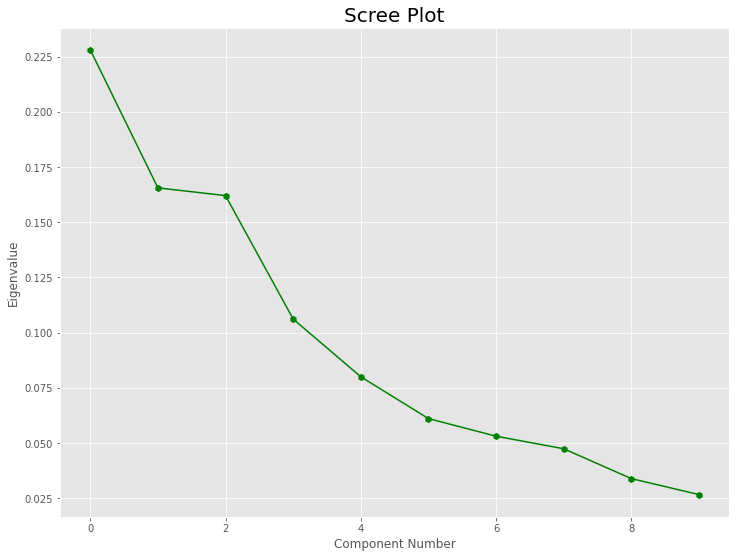

In [ ]:
model_pca = apply_pca(dataset_ss, 'features_clientes_scaled', 'features_clientes_scaled_out', 10)
scree_plot(model_pca)

In [ ]:
# Specify the k in k-means
kmeans = KMeans(k=3, seed=12, featuresCol="features_clientes_scaled", predictionCol="label")
model = kmeans.fit(dataset_ss)
clusterCenters = model.clusterCenters()
clusterCenters

[array([-0.55438553, -0.64407792, -0.2968716 ,  0.30564159,  0.80369418,
        -0.64076522,  0.74560913, -0.61017908,  0.66693688, -0.78001434,
         0.43859575, -0.44589292]),
 array([-0.15499994, -0.0197491 ,  0.35376338,  0.17783035,  0.05365911,
        -0.0711499 ,  0.45259226,  0.2969175 , -0.95335876,  0.97691731,
         0.1291823 , -0.01021454]),
 array([ 0.51139063,  0.43379919, -0.16291734, -0.37431423, -0.57031965,
         0.48307041, -0.93191242,  0.09534048,  0.52461362, -0.47547952,
        -0.41113671,  0.29685999])]

In [ ]:
df_prediction = model.transform(dataset_ss)
df_prediction.show()

+----+----------+----------------+---------------+----------------------+------------------+---------------------+---------+--------+------------------+-----------------+----------------+--------------------+------------------------+-----+
|Edad|Antiguedad|Espacios Parqueo|Velocidad Cajas|Distribucion Productos|Atencion Empleados|Calidad Instalaciones|Ubicacion|Limpieza|Variedad Productos|Prestigio Empresa|Calidad Servicio|   features_clientes|features_clientes_scaled|label|
+----+----------+----------------+---------------+----------------------+------------------+---------------------+---------+--------+------------------+-----------------+----------------+--------------------+------------------------+-----+
|  25|         1|               7|              6|                     7|                 6|                    7|        8|       9|                 7|                5|               0|[25.0,1.0,7.0,6.0...|    [-0.5386793549194...|    1|
|  24|         0|               4|      